# Classifiers for all targets
Let's train classifiers for all target for different molecular represenatations and compare results. The next step will involve the optimization of hyperparameters for each classifier. `mlflow` will be used for experiment management.<br>

To launch the mlflow server run:
```bash
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import polars as pl
from pathlib import Path
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

# add parent directory to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from metrics import ClassificationMetrics
from tools import expand_array_column, train_classifier

In [2]:
import mlflow
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_tracking_uri("sqlite:///../out/mlflow/mlflow.db")
mlflow.set_experiment("mol-reprs-benchmark")

2024/06/14 21:18:19 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/06/14 21:18:19 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/anton/Projects/PythonProjects/mol-reprs-benchmark/nbs/mlruns/1', creation_time=1718392699838, experiment_id='1', last_update_time=1718392699838, lifecycle_stage='active', name='mol-reprs-benchmark', tags={}>

In [3]:
path_parquet = Path("../data/2023_09_12_papyrus1k_dataset_more_params_STD_MFP_lessColumns.parquet")
assert path_parquet.exists()

Load precomputed Morgan fingerprints:

In [4]:
path_fps = Path("../out/fingerprints_dicts/d_morgan.pkl")
assert path_fps.exists()

with open(path_fps, "rb") as f:
    d_morgan = pickle.load(f)

Load data and train classifier:

In [5]:
df = pl.read_parquet(path_parquet)

In [6]:
# select randomly 5 targets
# random_targets = ['O94806_WT', 'P48729_WT', 'P80457_WT', 'Q16665_WT', 'P53667_WT']

metrics_lst = []

# for target_id in tqdm(random_targets):
for target_id in tqdm(df["target_id"].unique().to_list()):

    with mlflow.start_run():

        mlflow.set_tag("model_type", "random_forest")
        mlflow.set_tag("dataset", "Papyrus1K")

        mlflow.log_param("target_id", target_id)

        df_target = df.filter(pl.col("target_id") == target_id)
        df_target = df_target.drop(["target_id", "STD_SELFIES"])

        df_target = df_target.with_columns(
            morgan_fp = pl.col("STD_SMILES").map_elements(lambda x: d_morgan[x])
        )

        df_target = expand_array_column(df_target, "morgan_fp", 2048)

        # Define the model
        n_estimators = 1000
        random_state = 42
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("random_state", random_state)

        metrics = train_classifier(model, df_target, target_id)
        mlflow.log_metric("mcc_train", metrics.mcc_train)
        mlflow.log_metric("mcc_val", metrics.mcc_val)
        mlflow.log_metric("mcc_test", metrics.mcc_test)

        metrics_lst.append(metrics)

  0%|          | 0/280 [00:00<?, ?it/s]

In [7]:
metrics_lst

[Target: Q9Y337_WT, train MCC: 1.0000, val MCC: 0.7381, test MCC: 0.6984.,
 Target: P21917_WT, train MCC: 0.9939, val MCC: 0.3114, test MCC: 0.4167.,
 Target: O14920_WT, train MCC: 0.9976, val MCC: 0.7857, test MCC: 0.7713.,
 Target: P51449_WT, train MCC: 1.0000, val MCC: 0.4202, test MCC: 0.5493.,
 Target: Q03431_WT, train MCC: 1.0000, val MCC: 0.1866, test MCC: 0.1728.,
 Target: P35348_WT, train MCC: 1.0000, val MCC: 0.2192, test MCC: 0.5538.,
 Target: O43570_WT, train MCC: 1.0000, val MCC: 0.6218, test MCC: 0.7393.,
 Target: Q13526_WT, train MCC: 1.0000, val MCC: 0.0000, test MCC: 0.3133.,
 Target: O00519_WT, train MCC: 0.9834, val MCC: 0.7100, test MCC: 0.6231.,
 Target: P56817_WT, train MCC: 0.9985, val MCC: 0.6389, test MCC: 0.6960.,
 Target: P07333_WT, train MCC: 1.0000, val MCC: 0.7402, test MCC: 0.8195.,
 Target: P22303_WT, train MCC: 0.9896, val MCC: 0.7089, test MCC: 0.7377.,
 Target: O15530_WT, train MCC: 1.0000, val MCC: 0.8274, test MCC: 0.8409.,
 Target: Q8TDV5_WT, train

Visualize `mcc_val` score distribution:

In [8]:
metrics_dicts = []

for metrics in metrics_lst:
    metrics_dict = {
        "target_id": metrics.target_id,
        "mcc_train": metrics.mcc_train,
        "mcc_val": metrics.mcc_val,
        "mcc_test": metrics.mcc_test
    }
    metrics_dicts.append(metrics_dict)

In [9]:
df_metrics = pl.DataFrame(metrics_dicts)

df_metrics

target_id,mcc_train,mcc_val,mcc_test
str,f64,f64,f64
"""Q9Y337_WT""",1.0,0.738133,0.69843
"""P21917_WT""",0.993932,0.311443,0.416672
"""O14920_WT""",0.997587,0.785714,0.771291
"""P51449_WT""",1.0,0.420171,0.549254
"""Q03431_WT""",1.0,0.186567,0.172785
…,…,…,…
"""P10828_WT""",1.0,0.689319,0.677108
"""P51681_WT""",0.994506,0.643083,0.641638
"""P31639_WT""",1.0,0.492518,0.660207


In [10]:
# convert to pandas
df_metrics = df_metrics.to_pandas()

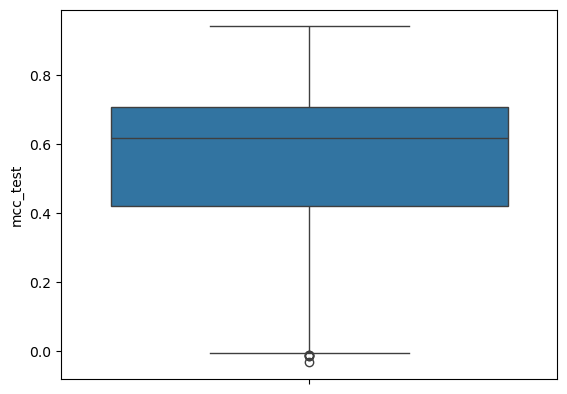

In [11]:
# violin plot
sns.boxplot(data=df_metrics, y="mcc_test");